In [2]:
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
import matplotlib.pyplot as plt
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.applications import VGG19

2023-10-30 10:35:13.275317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 10:35:13.699731: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 10:35:15.150762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-30 10:35:15.150921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png")
mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Training_GroundTruth/*.png")

In [4]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [5]:
def create_superpixel_ground_truth(img, ground_truth):

    # Perform superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # White pixels in ground truth are inside the region
    outside_mask = (ground_truth == 0)  # Black pixels in ground truth are outside the region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask, disk(3))
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # Yellow for inside superpixels
            inside_labels.append(label)
        else:
            color = (128, 128, 128)  # Blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Count superpixels that intersect with the boundary
    boundary_intersecting_superpixels = np.unique(labels[boundary_mask])
    num_boundary_intersecting_superpixels = len(boundary_intersecting_superpixels)

    return result

In [6]:
def dice_coef_one_class(y_true, y_pred, smooth=1e-7):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    intersection = K.sum(y_true_inside * y_pred_inside)
    denom = K.sum(y_true_inside) + K.sum(y_pred_inside)

    return (2. * intersection + smooth) / (denom + smooth)

def iou_one_class(y_true, y_pred, class_index=1, smooth=1):
    y_true_inside = K.cast(y_true == class_index, 'float32')
    y_pred_inside = y_pred[..., class_index]

    intersection = K.sum(y_true_inside * y_pred_inside)
    union = K.sum(y_true_inside) + K.sum(y_pred_inside) - intersection
    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score

def precision_one_class(y_true, y_pred):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    true_positives = K.sum(K.round(K.clip(y_true_inside * y_pred_inside, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_inside, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

def sensitivity_one_class(gt_mask, pred_mask, class_index=1):
    gt_mask_class = K.cast(gt_mask == class_index, 'float32')
    pred_mask_class = pred_mask [..., 1]

    TP = K.sum(gt_mask_class * pred_mask_class)
    FN = K.sum(gt_mask_class * (1 - pred_mask_class))

    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [9]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [10]:
def sensitivity(gt_mask, pred_mask):

    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [11]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef_one_class(y_true, y_pred, smooth=1e-7)

In [12]:
batch_size = 8
threshold_value = 128
from tqdm import tqdm
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_skin_slic800", os.path.basename(mask_path))
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (128, 128))

                    result = create_superpixel_ground_truth(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks


# generator = data_generator(image_paths, mask_paths, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)


In [13]:
# # Specify the path to the images
# image_folder = "/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_skin_slic800/"
# 
# # List all image files in the folder
# image_paths = glob.glob(os.path.join(image_folder, "*.png"))
# 
# # Process and overwrite each image in the same folder
# for image_path in image_paths:
#     # Load the image in color
#     image = cv2.imread(image_path)
# 
#     # Convert the image to grayscale
#     grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 
#     # Overwrite the original image with the grayscale version
#     cv2.imwrite(image_path, grayscale_image)
# 
# print("Image conversion and overwriting complete.")

In [14]:
mask_path_superpixel_label = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_skin_slic800/*.png")

# # Load one of the images
# image_path = mask_path_superpixel_label[0]  # Use the path to one of the images
# image = cv2.imread(image_path)  # Load as grayscale
# image_shape = image.shape
# 
# print("Image shape:", image_shape)

In [15]:
assert len(image_paths) == len(mask_path_superpixel_label), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_path_superpixel_label, test_size=0.2, random_state=2023
)

# Define the batch size
batch_size = 8

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

259
64


In [16]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs, num_classes=3):
    x = Conv2D(num_classes, (1, 1), padding="same")(inputs)
    x = Activation('softmax')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

# Modify the U-Net model to output 3 channels
def build_model(shape, num_classes=3):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x, num_classes)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x, num_classes)

    model = Model(inputs, outputs2)
    return model

In [17]:
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [18]:
weight_path="{}_Dunet_superpixel_skin.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2023-10-30 10:35:58.785455: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-30 10:35:58.785540: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-10-30 10:35:58.834769: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-10-30 10:35:58.835161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-30 10:35:58.872520: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-30 10:35:58.872821: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [19]:
shape = (128, 128, 3)  # Adjust the input shape to match your data
num_classes = 3  # Assuming you have 3 classes in your ground truth masks

# Create the double U-Net model
model = build_model(shape, num_classes=3)

opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_loss, metrics= [dice_coef_one_class, precision_one_class, iou_one_class, sensitivity_one_class],  run_eagerly=True)

model.summary()

2023-10-30 10:36:02.285128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 10:36:02.404696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 10:36:02.404954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 10:36:02.406725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [19]:

loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)
model.save("Dunet_superpixel_skin_slic800.h5")

/tmp/ipykernel_188996/1726412529.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(


Number of images: 2075
Number of masks: 2075
Epoch 1/50


2023-10-29 22:56:14.875252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2023-10-29 22:56:16.465969: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-29 22:56:16.470072: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-29 22:56:16.470125: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-10-29 22:56:16.470294: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

2023-10-29 22:56:25.479741: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-29 22:56:26.309928: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-10-29 22:56:26.580779: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

  1/259 [..............................] - ETA: 4:31:55 - loss: 0.8373 - dice_coef_one_class: 0.1627 - precision_one_class: 0.0234 - iou_one_class: 0.0886 - sensitivity_one_class: 0.2793

2023-10-29 22:57:15.603478: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-10-29 22:57:15.603512: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


  2/259 [..............................] - ETA: 5:16 - loss: 0.7723 - dice_coef_one_class: 0.2277 - precision_one_class: 0.3857 - iou_one_class: 0.1300 - sensitivity_one_class: 0.3034   

2023-10-29 22:57:16.683007: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-10-29 22:57:16.719544: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-10-29 22:57:16.790823: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 2813 callback api events and 2902 activity events. 
2023-10-29 22:57:16.815460: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-10-29 22:57:16.816800: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2023_10_29_22_57_16/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


259/259 [==============================] - ETA: 0s - loss: 0.4068 - dice_coef_one_class: 0.5932 - precision_one_class: 0.7432 - iou_one_class: 0.4350 - sensitivity_one_class: 0.7356Number of images: 519
Number of masks: 519

Epoch 1: val_loss improved from inf to 0.36295, saving model to cxr_reg_Dunet_superpixel_skin.best.hdf5
259/259 [==============================] - 807s 3s/step - loss: 0.4068 - dice_coef_one_class: 0.5932 - precision_one_class: 0.7432 - iou_one_class: 0.4350 - sensitivity_one_class: 0.7356 - val_loss: 0.3630 - val_dice_coef_one_class: 0.6370 - val_precision_one_class: 0.9174 - val_iou_one_class: 0.4753 - val_sensitivity_one_class: 0.6682 - lr: 1.0000e-04
Epoch 2/50
259/259 [==============================] - ETA: 0s - loss: 0.2761 - dice_coef_one_class: 0.7237 - precision_one_class: 0.7848 - iou_one_class: 0.5770 - sensitivity_one_class: 0.8167
Epoch 2: val_loss improved from 0.36295 to 0.29303, saving model to cxr_reg_Dunet_superpixel_skin.best.hdf5
259/259 [======

In [29]:
test_images = []
ground_truth_test_images = []

# define the paths to the images and their ground truths
test_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Test_Input/*.png')
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Test_GroundTruth/*.png")

In [30]:
model.load_weights("{}_Dunet_superpixel_skin.best.hdf5".format('cxr_reg'))

32/32 [==============================] - 9s 284ms/step
predicted mask grayscale shape: (1000, 128, 128, 3)
predicted mask shape: (1000, 128, 128, 3)
test images shape : (1000, 128, 128, 3)
ground truth test images shape: (1000, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float32, numpy=0.88039607>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8148629>, <tf.Tensor: shape=(), dtype=float32, numpy=0.667278>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8898366>, <tf.Tensor: shape=(), dtype=float32, numpy=0.92005646>, <tf.Tensor: shape=(), dtype=float32, numpy=0.95574725>, <tf.Tensor: shape=(), dtype=float32, numpy=0.83153176>, <tf.Tensor: shape=(), dtype=float32, numpy=0.76755655>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8342812>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9104916>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9382511>, <tf.Tensor: shape=(), dtype=float32, numpy=0.88372266>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94162345>, <tf.Tensor: shape=(), dtype=float

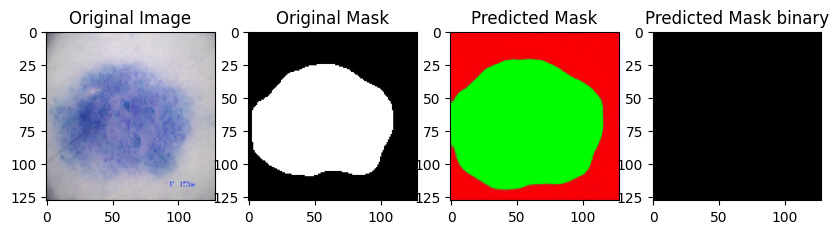

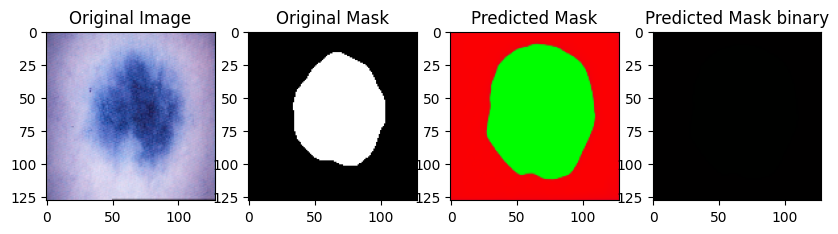

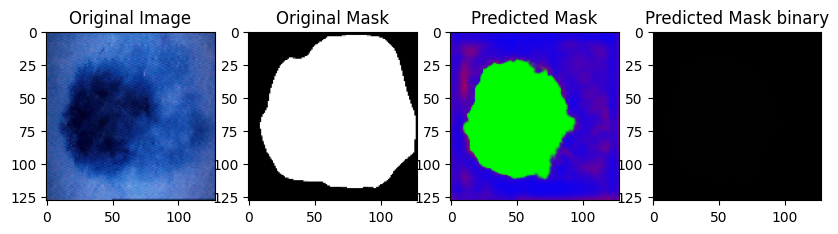

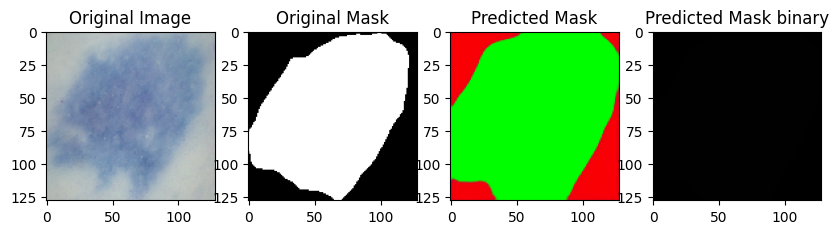

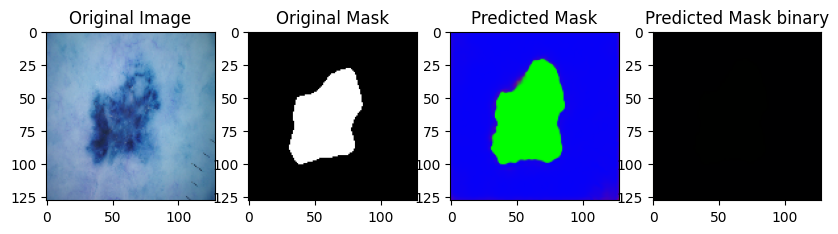

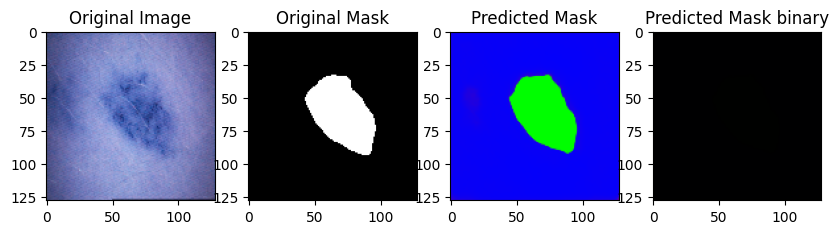

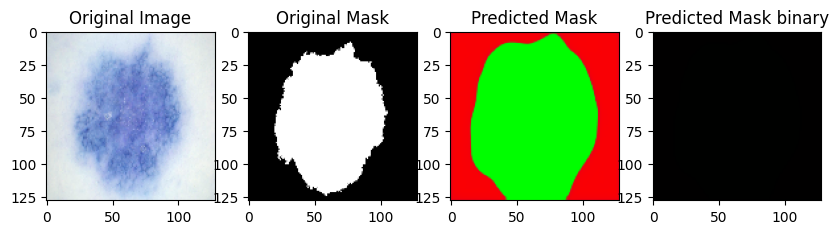

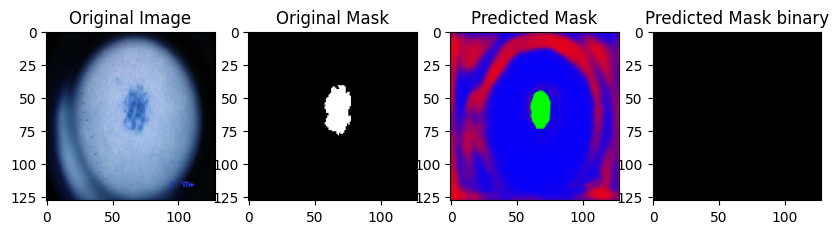

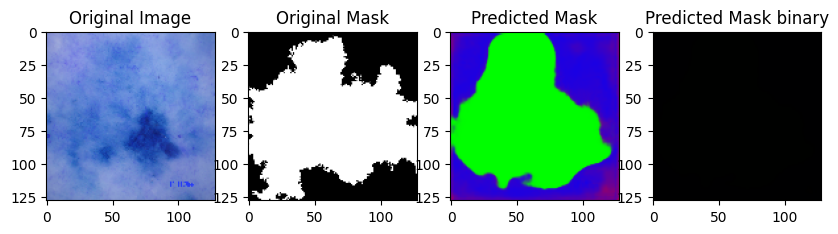

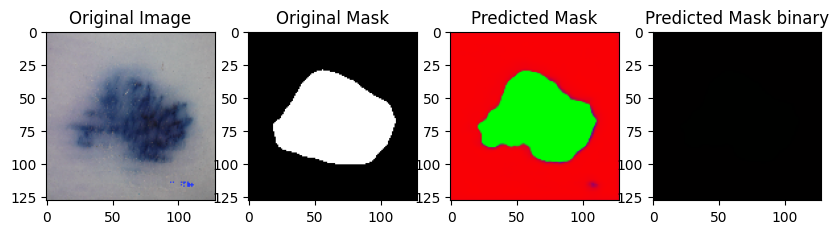

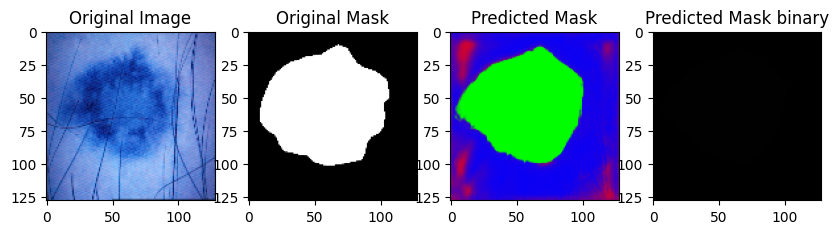

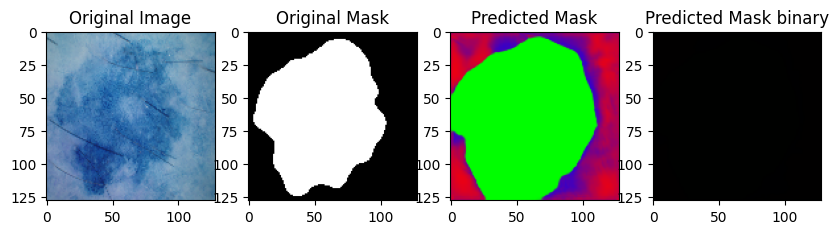

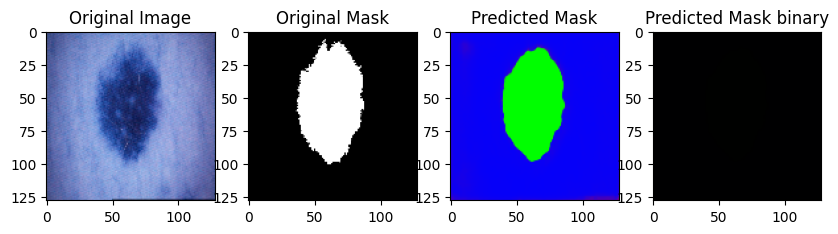

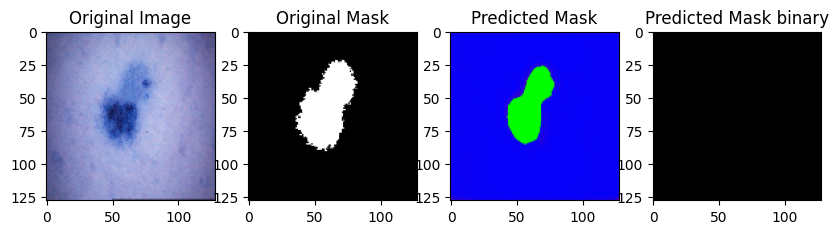

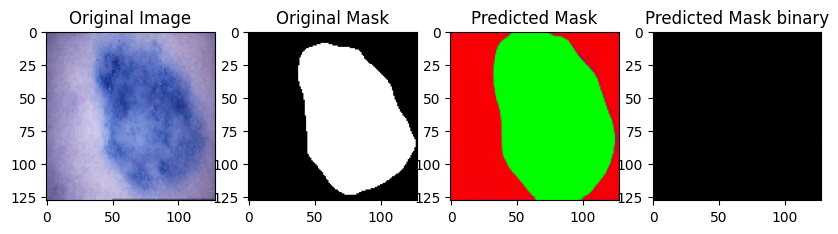

In [31]:
import random
dice_scores = []
import matplotlib.colors as mcolors

for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

    # normalize the image and mask to have values between 0 and 1
    test_image = test_image / 255.0
    ground_truth_test_image = ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)

# Convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)




# Make predictions
predicted_masks = model.predict(test_images)

threshold = 0.5  # You can adjust this threshold as needed

# Create an empty list to store the binary masks
binary_masks = []

# Convert the predicted masks to grayscale
# grayscale_mask = np.mean(predicted_masks, axis=-1)

# Apply the threshold to each predicted mask
for i in range(len(predicted_masks)):
    binary_mask = (predicted_masks[i] > threshold).astype(np.uint8)
    binary_masks.append(binary_mask)

# Convert the list of binary masks to a numpy array
binary_masks = np.array(binary_masks)


print("predicted mask grayscale shape:",binary_masks.shape)  # Shape after conversion
print("predicted mask shape:", predicted_masks.shape)
print("test images shape :", test_images.shape)
print ("ground truth test images shape:", ground_truth_test_images.shape)

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef_one_class(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)


for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision_one_class(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity_one_class(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou_one_class(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)


# Define a custom colormap
cmap_binary = mcolors.ListedColormap(['white', 'black'])  # 'black' for foreground, 'white' for background
n = 15
# Visualize the results for a subset of images

for i in range(n):

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i], cmap='gray')
    ax[1].set_title('Original Mask')
    ax[2].imshow(predicted_masks[i], cmap="gray")
    ax[2].set_title('Predicted Mask')
    ax[3].imshow(binary_masks[i], cmap="gray")
    ax[3].set_title('Predicted Mask binary')
    plt.show()